In [1]:
import numpy as np
from model import *
import tensorflow as tf
import setGPU
#strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])

imgs = np.expand_dims(np.load('../dataset/cv/train/x/generated_text.npz')['arr_0'], axis=-1)
labels = np.load('../dataset/cv/train/y/generated_labels.npy')

setGPU: Setting GPU to: 1


In [2]:
#imgs = imgs/255

In [3]:
characters = set(char for label in labels for char in label)

In [4]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
                  vocabulary=sorted(list(characters)), num_oov_indices=0, mask_token=None )

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
                  vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True )

In [5]:
imgs = np.transpose(imgs, (0, 2, 1, 3))
'''
max_len = max([len(label) for label in labels])
encoded_labels = []
for label in labels:
    if label:
        tmp = np.array([char_to_num(char) for char in label])
        encoded_labels.append(np.pad(tmp, (0, max_len-tmp.shape[0]), constant_values=0))
    else:
        tmp = np.array([char_to_num('#')])
        encoded_labels.append(np.pad(tmp, (0, max_len-tmp.shape[0]), constant_values=0))
'''

encoded_labels = np.load('../dataset/cv/train/y/encoded_generated_labels.npy')

In [6]:
#Si inserisce alla fine di ogni array label la lunghezza reale della parola
t_dist_dim = int(128)          # Questo valore indica quanti step temporali ci sono: nelle ultime feature map ci sono 128/4
                                 # step temporali perché 128 è la larghezza massima tra le immagini in ingresso e 4 è il fattore
                                 # di riduzione dovuto ai MaxPooling (ci sono 2 livelli di MaxPooling che dimezzano le dimensioni)
enc2 = []
for i in range(encoded_labels.shape[0]):
    if len(labels[i]) == 0:
        enc2.append(np.append(encoded_labels[i], [1, t_dist_dim]))
    else:
        enc2.append(np.append(encoded_labels[i], [len(labels[i]), t_dist_dim]))
enc2 = np.array(enc2)

In [8]:
#with strategy.scope():
net = build_and_compile_model_v10_5(input_shape=(128, 128, 1), len_characters=len(characters), opt="Adam")

In [9]:
net.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          activation[0][0]                 
_______________________________________________________________________________________

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Early_Stopping_Patience = 10 
Min_Delta = 0.0001
# Model Check Point
Check_Point = ModelCheckpoint( 'weights/CRNN_v10_5.h5',   # Filepath
                               monitor='val_loss',
                               save_best_only=True,
                               verbose=1,
                               mode='auto',
                               save_weights_only=False,
                               save_freq='epoch' )
# Add early stopping
Early_Stopping = EarlyStopping( monitor='val_loss',
                                min_delta=Min_Delta,
                                patience=Early_Stopping_Patience,
                                verbose=1,
                                mode='auto',
                                baseline=None,
                                restore_best_weights=True )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.0002)

In [11]:
batch_size = 64
x_train = imgs
y_train = enc2

In [12]:
history = net.fit(x_train, y_train, validation_split=0.2, epochs=100, callbacks=[Check_Point, reduce_lr], batch_size=batch_size, shuffle=True)

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 40.4280
Epoch 00001: val_loss improved from inf to 27.68022, saving model to weights/CRNN_v10_5.h5
125/125 [==============================] - 74s 590ms/step - loss: 40.4280 - val_loss: 27.6802
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 26.5816
Epoch 00002: val_loss improved from 27.68022 to 27.12128, saving model to weights/CRNN_v10_5.h5
125/125 [==============================] - 21s 170ms/step - loss: 26.5816 - val_loss: 27.1213
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 26.4227
Epoch 00003: val_loss improved from 27.12128 to 26.73323, saving model to weights/CRNN_v10_5.h5
125/125 [==============================] - 22s 176ms/step - loss: 26.4227 - val_loss: 26.7332
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 26.2117
Epoch 00004: val_loss improved from 26.73323 to 26.28610, saving model to weights/CRNN_v10_5.h5
125/125 [==============

125/125 [==============================] - ETA: 0s - loss: 0.3273
Epoch 00033: val_loss did not improve from 0.94949
125/125 [==============================] - 22s 177ms/step - loss: 0.3273 - val_loss: 1.0115
Epoch 34/100
125/125 [==============================] - ETA: 0s - loss: 0.3122
Epoch 00034: val_loss did not improve from 0.94949
125/125 [==============================] - 22s 176ms/step - loss: 0.3122 - val_loss: 1.1899
Epoch 35/100
125/125 [==============================] - ETA: 0s - loss: 0.2847
Epoch 00035: val_loss did not improve from 0.94949
125/125 [==============================] - 22s 177ms/step - loss: 0.2847 - val_loss: 1.1070
Epoch 36/100
125/125 [==============================] - ETA: 0s - loss: 0.2995
Epoch 00036: val_loss did not improve from 0.94949
125/125 [==============================] - 22s 177ms/step - loss: 0.2995 - val_loss: 1.0229
Epoch 37/100
125/125 [==============================] - ETA: 0s - loss: 0.2533
Epoch 00037: val_loss did not improve from 0.9

Epoch 70/100
125/125 [==============================] - ETA: 0s - loss: 0.0237
Epoch 00070: val_loss did not improve from 0.88063
125/125 [==============================] - 22s 176ms/step - loss: 0.0237 - val_loss: 1.0746
Epoch 71/100
125/125 [==============================] - ETA: 0s - loss: 0.0197
Epoch 00071: val_loss did not improve from 0.88063
125/125 [==============================] - 22s 177ms/step - loss: 0.0197 - val_loss: 1.0828
Epoch 72/100
125/125 [==============================] - ETA: 0s - loss: 0.0147
Epoch 00072: val_loss did not improve from 0.88063
125/125 [==============================] - 22s 178ms/step - loss: 0.0147 - val_loss: 1.0917
Epoch 73/100
125/125 [==============================] - ETA: 0s - loss: 0.0131
Epoch 00073: val_loss did not improve from 0.88063
125/125 [==============================] - 22s 177ms/step - loss: 0.0131 - val_loss: 1.0988
Epoch 74/100
125/125 [==============================] - ETA: 0s - loss: 0.0124
Epoch 00074: val_loss did not imp

In [ ]:
np.save('history/my_history_v5.npy',history.history)

In [23]:
import numpy as np
his = np.load('my_history_v5.npy', allow_pickle=True)

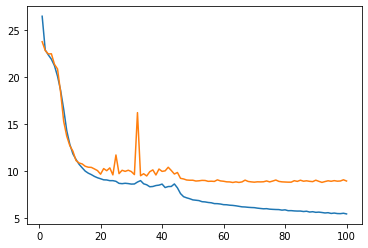

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(1, 101), history.history['loss'])
plt.plot(range(1, 101), history.history['val_loss'])

In [14]:
import imageio

im = imageio.imread('../dataset/cv/train/mario.png')

In [15]:
import cv2
from skimage import color

im = cv2.resize(im, (128, 128))
im = color.rgb2gray(im)

<ipython-input-15-d15eb699efec>:5: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  im = color.rgb2gray(im)


In [16]:
im = np.expand_dims(im, axis=-1)

In [17]:
def decode_ctc(args):
    """returns a list of decoded ctc losses"""

    y_pred, input_length = args

    ctc_decoded = tf.keras.backend.ctc_decode(
        y_pred, input_length, greedy=True)

    return ctc_decoded

In [21]:
pred_tensor, _ = decode_ctc([net.predict(np.expand_dims(im, axis=0)), np.array([t_dist_dim])])
pred_labels = tf.keras.backend.get_value(pred_tensor[0])

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [22]:
pred_labels

array([[14, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [23]:
num_to_char(pred_labels)

<tf.Tensor: shape=(1, 128), dtype=string, numpy=
array([[b'E', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[

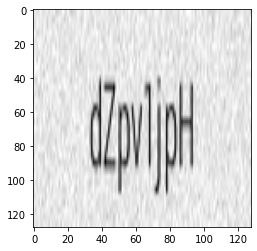

In [33]:
import matplotlib.pyplot as plt
plt.imshow(im, cmap='gray')
plt.show()

In [15]:
net.load_weights('weights/CRNN_v10_5.h5')

Missing modules for handwritten text generation.


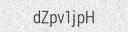

In [27]:
from trdg.generators import GeneratorFromRandom  
base_generator = GeneratorFromRandom(use_symbols=False, use_letters=True, length=1, width=128, size=32)
img, lbl = next(base_generator)
display(img)

In [29]:
import cv2
from skimage import color
im = cv2.resize(np.array(img), (128, 128))
im = color.rgb2gray(im)
im = np.expand_dims(im, axis=-1)

In [30]:
pred_tensor, _ = decode_ctc([net.predict(np.expand_dims(im, axis=0)), np.array([t_dist_dim])])
pred_labels = tf.keras.backend.get_value(pred_tensor[0])

In [31]:
pred_labels

array([[14, 25, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [32]:
num_to_char(pred_labels)

<tf.Tensor: shape=(1, 128), dtype=string, numpy=
array([[b'E', b'P', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]

In [26]:
labels[50]

'ht'